<a href="https://colab.research.google.com/github/xXWeIsLyXx/APS360/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### 0.0 install dependencies
!pip install librosa
!pip install pydub 

In [2]:
# 0.1 import dependencies

import os
import librosa
import math
import json
from librosa import display
import matplotlib.pyplot as plt
import scipy.fft as fft
import pandas as pd
import numpy as np

import soundfile as sf
import matplotlib.pyplot as plt
from os import path
from pydub import AudioSegment
import scipy.io.wavfile as wav

import torch 
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

import glob
from sklearn import preprocessing

In [3]:
# 0.2 mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# 0.3 import metadata
root_path = "/content/gdrive/MyDrive/APS360_project"
tracks = pd.read_csv(root_path + '/fma_metadata/tracks.csv', header=1, index_col=[0])

tracks_genre = tracks[tracks.subset == "small"].filter(["track_id", "genre_top"])

# divide tracks into genres

genres = ['Rock', 'Hip-Hop', "Electronic", "Folk"]

tracks_rock = tracks_genre.where(tracks_genre['genre_top'] == 'Rock').dropna()

tracks_hip_hop = tracks_genre.where(tracks_genre['genre_top'] == 'Hip-Hop').dropna()

tracks_elec = tracks_genre.where(tracks_genre['genre_top'] == 'Electronic').dropna()

tracks_folk = tracks_genre.where(tracks_genre['genre_top'] == 'Folk').dropna()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#0.4 MFCC extraction 
def get_mp3_path(tracks_genre, id):
  track_num = str(tracks_genre.iloc[id].name)
  print(f" ({track_num}) ", end="")
  filename  = (6-len(track_num))*'0' + track_num
  mp3_path = "/" + filename[:3] + "/" + filename + ".mp3"
  print(f"{mp3_path}")
  return mp3_path

mp3_root = root_path + '/fma_small'

tracks_genres = [tracks_rock, tracks_hip_hop, tracks_elec, tracks_folk]

WAVE_PATH = root_path + "/wav_files"



hop_length = 5
num_segments = 50

SAMPLES_PER_TRACK = 50
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

audios = []
labels = []


for track_genre in tracks_genres:
    genre = track_genre.genre_top.iloc[0]
    print(f"Getting coefficients for {track_genre.genre_top.iloc[0]} genre...")
    for i in range(0,50):
        dest = "/" + genre + "/track" + str(i) + ".wav"
        mp3_file = get_mp3_path(track_genre, i)
        sound = AudioSegment.from_mp3(mp3_root + mp3_file)
        sound.export(WAVE_PATH + dest, format="wav")
        sig, rate = librosa.load(WAVE_PATH + dest) 

        # process all segments of audio file
        temp =[]
        for d in range(num_segments):
          # calculate start and finish sample for current segment
          start = samples_per_segment * d
          finish = start + samples_per_segment

          # extract mfcc
          mfcc = librosa.feature.mfcc(sig[start:finish], rate, n_mfcc=13, hop_length=1024)
          temp.append(mfcc)
          # audios.append(mfcc.tolist())

        temp=np.concatenate(temp)
        temp = temp.T
        audios.append(temp)
        labels.append(genre)
audios = np.concatenate(audios)



Getting coefficients for Rock genre...


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1
  n_fft, y.shape[-1]


Getting coefficients for Hip-Hop genre...
Getting coefficients for Electronic genre...
Getting coefficients for Folk genre...


In [8]:
# 0.5 Split and save dataset

# load data
X = np.array(audios)
y = np.array(labels)
X = torch.Tensor(X)
 # create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.1, train_size=0.9, shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, train_size = 0.7, shuffle=True)

X_train = torch.from_numpy(X_train)
X_validation = torch.from_numpy(X_validation)
X_test = torch.from_numpy(X_test)

torch.save(X_train, "/content/gdrive/MyDrive/APS360_project/X_train.pth")
torch.save(X_validation, "/content/gdrive/MyDrive/APS360_project/X_validation.pth")
torch.save(X_test, "/content/gdrive/MyDrive/APS360_project/X_test.pth")

le = preprocessing.LabelEncoder()
targets_train = le.fit_transform(y_train)
targets_train = torch.from_numpy(targets_train)
torch.save(targets_train, "/content/gdrive/MyDrive/APS360_project/targets_train.pth")

ls =  preprocessing.LabelEncoder()
targets_validation = ls.fit_transform(y_validation)
targets_validation = torch.from_numpy(targets_validation)
torch.save(targets_validation, F"/content/gdrive/MyDrive/APS360_project/targets_validation.pth")

lt =  preprocessing.LabelEncoder()
targets_test = lt.fit_transform(y_test)
targets_test = torch.from_numpy(targets_test)
torch.save(targets_test, F"/content/gdrive/MyDrive/APS360_project/targets_test.pth")


In [9]:
# 0.6 RNN-LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, batch_size, num_layers):
        super(LSTMModel, self).__init__()
        
        self.input_size = input_size #input size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_1 = nn.LSTM(input_size, 64, batch_first=True)
        self.lstm_2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*1*1, hidden_size*1*1)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size*1*1, num_classes)

    def init_state(self, batch_size):
      self.batch_size = batch_size
      return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    def forward(self, x):
        x = x.unsqueeze(0)
        x = x.unsqueeze(1)
        # print(x.size())
        hs = self.init_state(1)
        x, hs = self.lstm_1(x,hs)
        # out, _ = self.rnn(x, h0)
        # print(x.size())
        # x = self.lstm_2(x)
        x = self.dropout(nn.functional.relu(self.fc1(x[:, -1, :])))
        x = nn.functional.softmax(self.fc2(x), dim = 1)
        return x
      

In [10]:
# 0.7 Training code 

def get_accuracy(model, X_dataset, y_dataset, batch_size):
    correct, total = 0, 0
    for audios in X_dataset:
      for labels in y_dataset:
        output = model(audios)
        pred = output.max(1, keepdim=True)[1]
        # correct += (torch.max(audios, 1)[1]).sum()
        correct += pred.eq(labels.view_as(pred)).sum().item()
        # total = y_dataset.shape[0]
    return  correct / batch_size

def train(model, X_train, X_validation, y_train, y_validation, batch_size, num_epochs, learning_rate):
  # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
  is_cuda = torch.cuda.is_available()

  # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
  if is_cuda:
      device = torch.device("cuda")
      print("GPU is available")
  else:
      device = torch.device("cpu")
      print("GPU not available, CPU used")
      
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
  # val_loader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=False, batch_size=batch_size)

  losses, train_acc, valid_acc = [], [], []
  epochs = []
  for epoch in range(num_epochs):
        for i in X_train:
          for j in y_train: 
            # print(labels)
            optimizer.zero_grad()
            # print(audios)
            i = i.view(650)
            j = j.view(1)
            pred = model(i)
            loss = criterion(pred, j)
            loss.backward()
            optimizer.step()
            
        losses.append(float(loss))     
        if epoch % 5 == 4:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, X_train, y_train, batch_size=batch_size))
            valid_acc.append(get_accuracy(model, X_validation, y_validation, batch_size=batch_size))
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

# plotting
  plt.title("Training Curve")
  plt.plot(losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(valid_acc[-1]))

GPU not available, CPU used
Epoch 5; Loss 1.417204; Train Acc 68.359375; Val Acc 4.500000
Epoch 10; Loss 1.411268; Train Acc 68.359375; Val Acc 4.500000
Epoch 15; Loss 1.398963; Train Acc 68.359375; Val Acc 4.500000
Epoch 20; Loss 1.403062; Train Acc 68.359375; Val Acc 4.500000
Epoch 25; Loss 1.399163; Train Acc 68.359375; Val Acc 4.500000


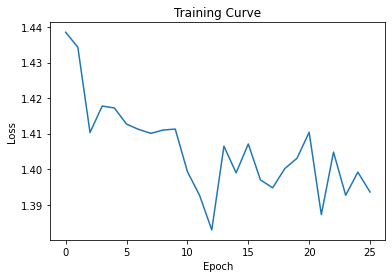

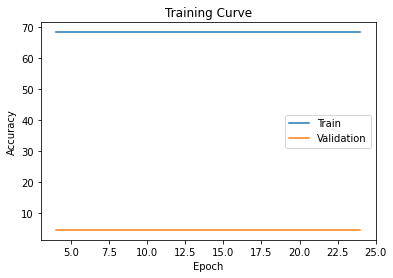

Final Training Accuracy: 68.359375
Final Validation Accuracy: 4.5


In [11]:
# 0.8 Create and train model 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = (X_train.shape[1])
model = LSTMModel(input_size=input_size, hidden_size=64, num_classes=4, batch_size=64, num_layers=1)
train(model, X_train, X_validation, targets_train, targets_validation, batch_size=64, num_epochs=26, learning_rate=1e-5)